In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
import astropy.stats as st


from matplotlib import rcParams
# rcParams["font.size"] = 14
# rcParams["text.usetex"] = True
# rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function

In [262]:
inFile = 'corrected_mags_linewidth_all.csv.test'

table   = np.genfromtxt(inFile , delimiter='|', filling_values=-99999, names=True, dtype=None, encoding=None)

Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
inc = table['inc']
u0 = table['u']
g0 = table['g']
r0 = table['r']
i0 = table['i']
z0 = table['z']
w10 = table['w1']
w20 = table['w2']

u_s = table['u_s']
g_s = table['g_s']
r_s = table['r_s']
i_s = table['i_s']
z_s = table['z_s']
w1_s = table['w1_s']
w2_s = table['w2_s']

u_ss = table['u_ss']
g_ss = table['g_ss']
r_ss = table['r_ss']
i_ss = table['i_ss']
z_ss = table['z_ss']
w2_ss = table['w2_ss']

u_sss = table['u_sss']
g_sss = table['g_sss']
r_sss = table['r_sss']
i_sss = table['i_sss']
z_sss = table['z_sss']
w1_sss = table['w1_sss']
w2_sss = table['w2_sss']

R_source = table['R_source']

gamma_u = table['gamma_u']
gamma_g = table['gamma_g']
gamma_r = table['gamma_r']
gamma_i = table['gamma_i']
gamma_z = table['gamma_z']
gamma_w1 = table['gamma_w1']
gamma_w2 = table['gamma_w2']

gamma_p_u = table['gamma_p_u']
gamma_p_g = table['gamma_p_g']
gamma_p_r = table['gamma_p_r']
gamma_p_i = table['gamma_p_i']
gamma_p_z = table['gamma_p_z']
gamma_p_w1 = table['gamma_p_w1']
gamma_p_w2 = table['gamma_p_w2']



logWimx = table['logWimx']

N = len(Sqlt)
q = np.zeros(N)

q[np.where(Sqlt>3)]+=1
q[np.where(Wqlt>3)]+=1
indx, = np.where(q==2)

nan
0.31523818350324373
2.04 0.36 2.04 0.33 -0.04
2.12 0.35 2.12 0.33 -0.02
2.20 0.37 2.20 0.37 0.00
2.28 0.42 2.28 0.42 -0.00
2.36 0.48 2.36 0.48 0.00
2.44 0.54 2.44 0.53 -0.00
2.52 0.55 2.52 0.56 0.01
2.60 0.52 2.60 0.54 0.02
2.68 0.49 2.68 0.48 -0.01
2.76 0.43 2.76 0.42 -0.01


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Text(0.5,1,'after correction')

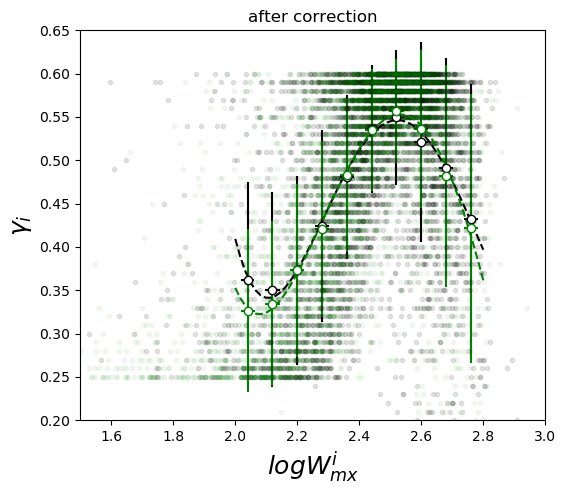

In [275]:
A_p_r = table['A_p_r']
Ar    = table['Ar']

A_p_i = table['A_p_i']
Ai    = table['Ai']

A_p_z = table['A_p_z']
Az    = table['Az']

gamma_p_i = table['gamma_p_i']
# c = [   6.05789407,  -56.2981331,   194.7882034,  -297.41922462,  169.16712707]
# n = len(c)-1
# for i in range(n+1): gamma_p_i =  gamma_p_i + c[i]*logWimx**(n-i)

gamma_i   = table['gamma_i']

X1 = logWimx[(R_source==2) & (gamma_i<1)]
X2 = logWimx[R_source==0]

# Y1 = Az[R_source==2]
# Y2 = A_p_z[R_source==0]

Y1 = gamma_i[(R_source==2) & (gamma_i<1)]
Y2 = gamma_p_i[R_source==0]


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(X1, Y1, 'k.', alpha=0.1)
ax.plot(X2, Y2, 'g.', alpha=0.05)



print np.mean(Ai[R_source==2])
print np.mean(A_p_i[R_source==0])


X = X1
Y = Y1
Lxx1 = []
Lyy1 = []
Lyy1e = []
for i in np.arange(2.,2.8,0.08):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.08:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+0.04 # np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='black', ms=6, mfc='white')  
        Lxx1.append(xx)
        Lyy1.append(yy)  
        Lyy1e.append(np.std(yp))  
        
X = X2
Y = Y2
Lxx2 = []
Lyy2 = []
Lyy2e = []
for i in np.arange(2.,2.8,0.08):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.08:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+0.04 # np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white')    
        Lxx2.append(xx)
        Lyy2.append(yy)       
        Lyy2e.append(np.std(yp))  
        
for i in range(len(Lxx1)):
    d = Lyy2[i]-Lyy1[i]
    print '%.2f'%Lxx1[i], '%.2f'%Lyy1[i], '%.2f'%Lxx2[i], '%.2f'%Lyy2[i], '%.2f'%d
    

v = np.linspace(2,2.8,50)
Lxx1 = np.asarray(Lxx1)
Lxx2 = np.asarray(Lxx2)
Lyy1 = np.asarray(Lyy1)
Lyy2 = np.asarray(Lyy2)
Lyy1e = np.asarray(Lyy1e)
Lyy2e = np.asarray(Lyy2e)

n = 4
c1 = np.polyfit(Lxx1, Lyy1, n, w=1./Lyy1e)
cy1 = v*0
for i in range(n+1): cy1+=c1[i]*v**(n-i)
ax.plot(v, cy1, 'k--')

c2 = np.polyfit(Lxx2, Lyy2, n, w=1./Lyy2e)
cy2 = v*0
for i in range(n+1): cy2+=c2[i]*v**(n-i)
ax.plot(v, cy2, 'g--')

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$\gamma_i$', fontsize=18) 


ax.set_ylim(0.2,0.65)
ax.set_xlim(1.5,3)

ax.set_title('after correction')

[   2.62875281  -25.20839157   90.52672839 -144.31772035   86.19219398]


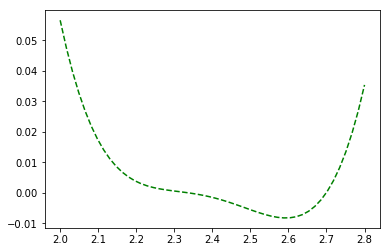

In [264]:
c = c1-c2
plt.plot(v,c[0]*v**4+c[1]*v**3+c[2]*v**2+c[3]*v+c[4], 'g--')

print c

(array([  53.,   12.,   27.,   37.,  358.,  341.,  360.,  519.,  772.,
        2505.]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ]),
 <a list of 1 Patch objects>)

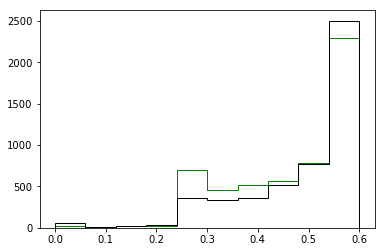

In [265]:
_, bins, _ =  plt.hist(Y2, histtype='step', label='0', color='g')
plt.hist(Y1,  histtype='step', label='2', color='k', bins=bins)

(array([1.000e+00, 2.000e+00, 9.000e+00, 3.900e+01, 1.260e+02, 4.610e+02,
        1.256e+03, 1.823e+03, 1.173e+03, 9.300e+01]),
 array([1.219 , 1.3912, 1.5634, 1.7356, 1.9078, 2.08  , 2.2522, 2.4244,
        2.5966, 2.7688, 2.941 ]),
 <a list of 1 Patch objects>)

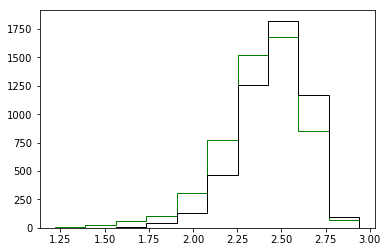

In [266]:
_, bins, _ =  plt.hist(X2, fill=False, histtype='step', label='0', color='g')
plt.hist(X1, fill=False, histtype='step', label='2', color='k', bins=bins)


In [267]:
print len(Sqlt)

print len(np.where(R_source==0)[0])
print len(np.where(R_source==1)[0])
print len(np.where(R_source==2)[0])

print len(np.where((Sqlt>0) & (Wqlt>0))[0])




10737
5395
355
4987
2244


nan
[ 0.    0.   -0.01 ...  0.03 -0.01  0.  ]
-0.000621581302834416


(array([2.00e+00, 8.00e+00, 2.40e+01, 9.80e+01, 1.74e+03, 1.17e+02,
        1.50e+01, 3.00e+00, 3.00e+00, 1.00e+00]),
 array([-0.39 , -0.303, -0.216, -0.129, -0.042,  0.045,  0.132,  0.219,
         0.306,  0.393,  0.48 ]),
 <a list of 10 Patch objects>)

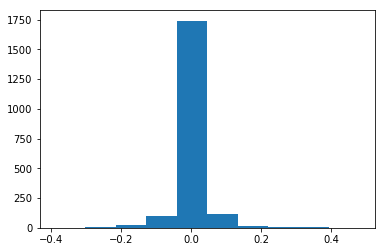

In [268]:
A_p_i = table['A_p_i']
Ai    = table['Ai']

print np.median(Ai-(A_p_i-0.05))


N = len(Sqlt)
q = np.zeros(N)
q[np.where(Sqlt>3)]+=1
q[np.where(Wqlt>3)]+=1
indx, = np.where(q==2)
RS = R_source[indx]
D = i_s[indx]-i_ss[indx]
D = D[RS==2]
print D
print np.mean(D)

plt.hist(D)

In [269]:
print np.mean(Ai[R_source==2]), np.std(Ai[R_source==2])
print np.mean(A_p_i[R_source==0]), np.std(A_p_i[R_source==0])

nan nan
0.31523818350324373 0.20671272770449364


47.50 0.49 47.50 0.51 0.01
52.50 0.50 52.50 0.50 -0.00
57.50 0.50 57.50 0.49 -0.01
62.50 0.49 62.50 0.49 0.00
67.50 0.50 67.50 0.49 -0.01
72.50 0.50 72.50 0.48 -0.01
77.50 0.49 77.50 0.46 -0.03
82.50 0.49 82.50 0.46 -0.02
87.50 0.47 87.50 0.45 -0.03


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


(0, 1)

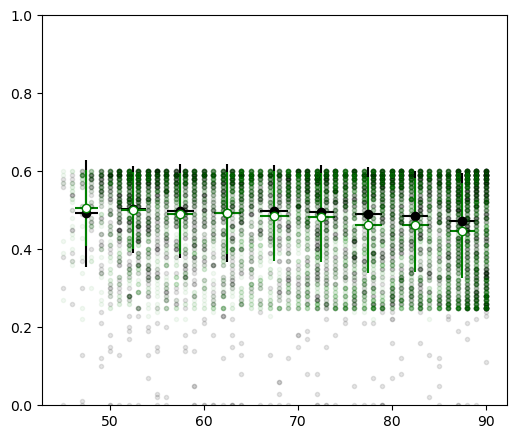

In [270]:
A_p_r = table['A_p_r']
Ar    = table['Ar']

A_p_i = table['A_p_i']
Ai    = table['Ai']

A_p_z = table['A_p_z']
Az    = table['Az']

gamma_p_i = table['gamma_p_i']

gamma_i   = table['gamma_i']


Y1 = gamma_i[(R_source==2) & (gamma_i<1)]
Y2 = gamma_p_i[(R_source==0) & (logWimx<10) & (gamma_p_i>0.21) & (gamma_p_i<0.7)]

X1 = inc[(R_source==2) & (gamma_i<1)]
X2 = inc[(R_source==0) & (logWimx<10) & (gamma_p_i>0.21) & (gamma_p_i<0.7)]


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(X1, Y1, 'k.', alpha=0.1)
ax.plot(X2, Y2, 'g.', alpha=0.05)


X = X1
Y = Y1
Lxx1 = []
Lyy1 = []
Lyy1e = []
for i in np.arange(45,90,5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+2.5# np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='black', ms=6)  
        Lxx1.append(xx)
        Lyy1.append(yy)  
        Lyy1e.append(np.std(yp))  
        
X = X2
Y = Y2
Lxx2 = []
Lyy2 = []
Lyy2e = []
for i in np.arange(45,90,5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+2.5# np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white')    
        Lxx2.append(xx)
        Lyy2.append(yy)       
        Lyy2e.append(np.std(yp))  
        
for i in range(len(Lxx1)):
    d = Lyy2[i]-Lyy1[i]
    print '%.2f'%Lxx1[i], '%.2f'%Lyy1[i], '%.2f'%Lxx2[i], '%.2f'%Lyy2[i], '%.2f'%d

ax.set_ylim(0,1)

46.00 0.48 46.00 -0.25 -0.72
48.00 0.57 48.00 0.36 -0.21
50.00 0.60 50.00 0.21 -0.39
52.00 0.31 52.00 0.13 -0.18
54.00 0.49 54.00 0.15 -0.34
56.00 0.45 56.00 0.14 -0.31
58.00 0.21 58.00 -0.03 -0.23
60.00 0.49 60.00 -0.18 -0.66
62.00 0.19 62.00 -0.13 -0.32
64.00 0.28 64.00 -0.15 -0.44
66.00 0.15 66.00 -0.20 -0.36
68.00 0.10 68.00 -0.26 -0.36
70.00 0.05 70.00 -0.34 -0.39
72.00 0.18 72.00 -0.46 -0.64
74.00 0.03 74.00 -0.40 -0.43
76.00 -0.02 76.00 -0.64 -0.62
78.00 -0.03 78.00 -0.77 -0.74
80.00 -0.15 80.00 -0.63 -0.48
82.00 inf 82.00 -0.75 -inf
84.00 -0.28 84.00 -0.93 -0.65
86.00 -0.38 86.00 -1.07 -0.69
88.00 -0.51 88.00 -0.93 -0.43
90.00 -0.91 90.00 -1.29 -0.37
0.0
-0.14


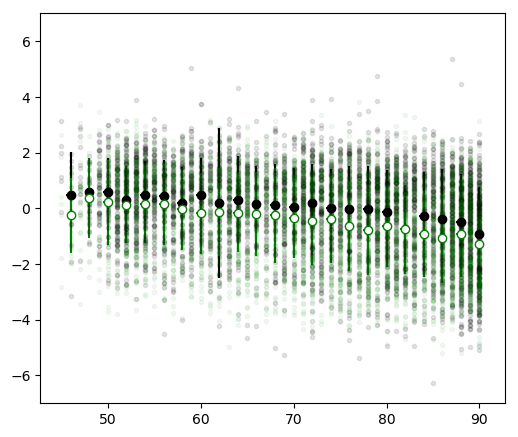

In [271]:
P0_w2  = table['P0_w2']
P0_w2p = table['P0_w2p']  ####+1.0


Y1 = P0_w2[(R_source==2)]
Y2 = P0_w2p[R_source==0]

X1 = inc[(R_source==2)]
X2 = inc[R_source==0]


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(X1, Y1, 'k.', alpha=0.1)
ax.plot(X2, Y2, 'g.', alpha=0.05)



X = X1
Y = Y1
Lxx1 = []
Lyy1 = []
Lyy1e = []
for i in np.arange(45,90,2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+1# np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='black', ms=6)  
        Lxx1.append(xx)
        Lyy1.append(yy)  
        Lyy1e.append(np.std(yp))  
        
X = X2
Y = Y2
Lxx2 = []
Lyy2 = []
Lyy2e = []
for i in np.arange(45,90,2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+1# np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white')    
        Lxx2.append(xx)
        Lyy2.append(yy)       
        Lyy2e.append(np.std(yp))  
        
for i in range(len(Lxx1)):
    d = Lyy2[i]-Lyy1[i]
    print '%.2f'%Lxx1[i], '%.2f'%Lyy1[i], '%.2f'%Lxx2[i], '%.2f'%Lyy2[i], '%.2f'%d

ax.set_ylim(-7,7)

print np.median(P0_w2)
print np.median(P0_w2p)

[-0.00535663 -0.08831901]
-0.4528289447832336


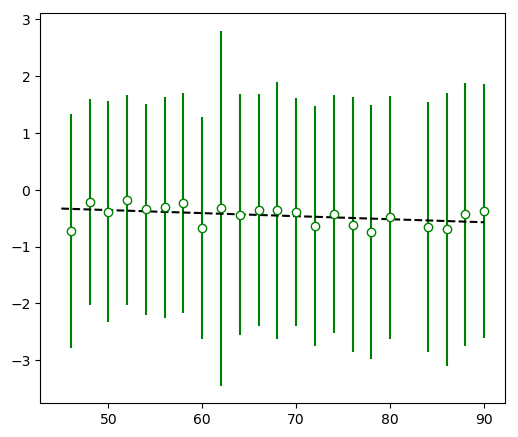

In [272]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

Lxx1 = np.asarray(Lxx1)
Lxx2 = np.asarray(Lxx2)
Lyy1 = np.asarray(Lyy1)
Lyy2 = np.asarray(Lyy2)
Lyy1e = np.asarray(Lyy1e)
Lyy2e = np.asarray(Lyy2e)
yerr = np.sqrt(Lyy1e**2+Lyy2e**2)


v = np.linspace(45,90,50)
D = Lyy2-Lyy1

n = 1
c1 = np.polyfit(Lxx1[D>-100], D[D>-100], n, w=1./yerr[D>-100])
cy1 = v*0
for i in range(n+1): cy1+=c1[i]*v**(n-i)
ax.plot(v, cy1, 'k--')

ax.errorbar(Lxx1[D>-100], D[D>-100], yerr=yerr[D>-100], fmt='o', 
                    color='green', ms=6, mfc='white')  

print c1

print np.mean(D[D>-100])

1.85 -3.15 1.85 -2.97 0.18
1.95 -2.32 1.95 -2.62 -0.30
2.05 -2.44 2.05 -2.49 -0.04
2.15 -2.03 2.15 -2.24 -0.21
2.25 -1.63 2.25 -1.60 0.03
2.35 -0.94 2.35 -0.97 -0.03
2.45 inf 2.45 -0.14 -inf
2.55 0.62 2.55 0.59 -0.03
2.65 1.18 2.65 1.18 -0.00
2.75 1.56 2.75 1.61 0.05
0.0
-0.14


Text(0.5,1,'after correction')

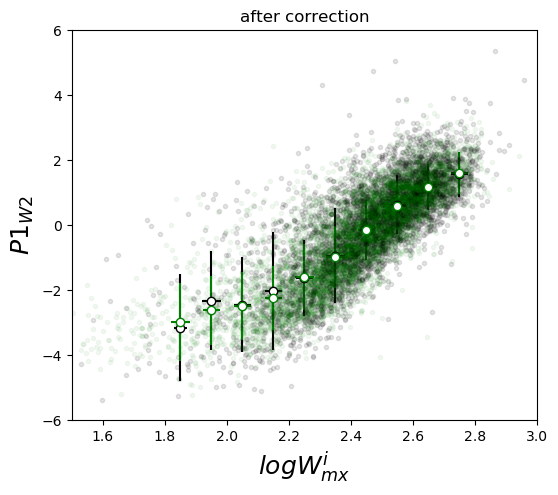

In [277]:
P0_w2  = table['P0_w2']
P0_w2p = table['P0_w2p']  ####+1.0


Y1 = P0_w2[(R_source==2)]
Y2 = P0_w2p[R_source==0]

X1 = logWimx[(R_source==2)]
X2 = logWimx[R_source==0]


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(X1, Y1, 'k.', alpha=0.1)
ax.plot(X2, Y2, 'g.', alpha=0.05)



X = X1
Y = Y1
Lxx1 = []
Lyy1 = []
Lyy1e = []
for i in np.arange(1.8,2.8,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+0.05# np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='black', ms=6, mfc='white')  
        Lxx1.append(xx)
        Lyy1.append(yy)  
        Lyy1e.append(np.std(yp))  
        
X = X2
Y = Y2
Lxx2 = []
Lyy2 = []
Lyy2e = []
for i in np.arange(1.8,2.8,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xx = i+0.05# np.median(xp)
        yy = np.mean(yp)
        ax.errorbar(xx, yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white')    
        Lxx2.append(xx)
        Lyy2.append(yy)       
        Lyy2e.append(np.std(yp))  
        
for i in range(len(Lxx1)):
    d = Lyy2[i]-Lyy1[i]
    print '%.2f'%Lxx1[i], '%.2f'%Lyy1[i], '%.2f'%Lxx2[i], '%.2f'%Lyy2[i], '%.2f'%d

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$P1_{W2}$', fontsize=18) 


ax.set_ylim(-6,6)
ax.set_xlim(1.5,3)

print np.median(P0_w2)
print np.median(P0_w2p)
                
ax.set_title('after correction')

ValueError: On entry to DLASCL parameter number 4 had an illegal value

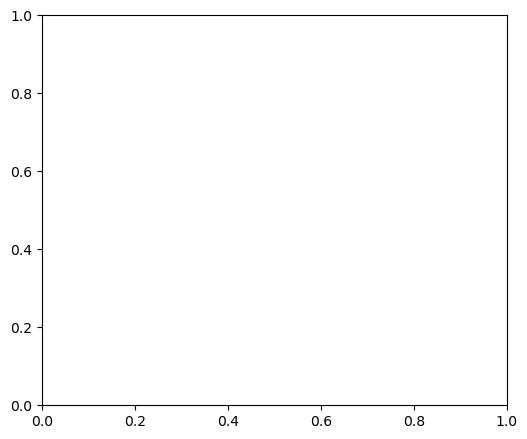

In [274]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

Lxx1 = np.asarray(Lxx1)
Lxx2 = np.asarray(Lxx2)
Lyy1 = np.asarray(Lyy1)
Lyy2 = np.asarray(Lyy2)
Lyy1e = np.asarray(Lyy1e)
Lyy2e = np.asarray(Lyy2e)
yerr = np.sqrt(Lyy1e**2+Lyy2e**2)


v = np.linspace(1.8,3,50)

n = 1
c1 = np.polyfit(Lxx1, Lyy2-Lyy1, n, w=1./Lyy1e)
cy1 = v*0
for i in range(n+1): cy1+=c1[i]*v**(n-i)
ax.plot(v, cy1, 'k--')


ax.errorbar(Lxx1, Lyy2-Lyy1, yerr=np.std(yerr), fmt='o', 
                    color='green', ms=6, mfc='white')  

print c1


ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$\Delta P1_{W2}$', fontsize=18) 

ax.set_title(r'$\Delta = measurement-prediction$')

### Genrating comparison plots for quality data

All galaxies in this subsample have both SDSS and WISE photometry with user reported quality of at elast 2, i.e. Wsql>1 and Sqlt>1.



In [204]:
print len(indx) # get the number of galaxies used in the following plots

2044


In [13]:
def rmsMaker(X):
    

    Y_fit2 = X
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))
    
    
 
    return rms

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


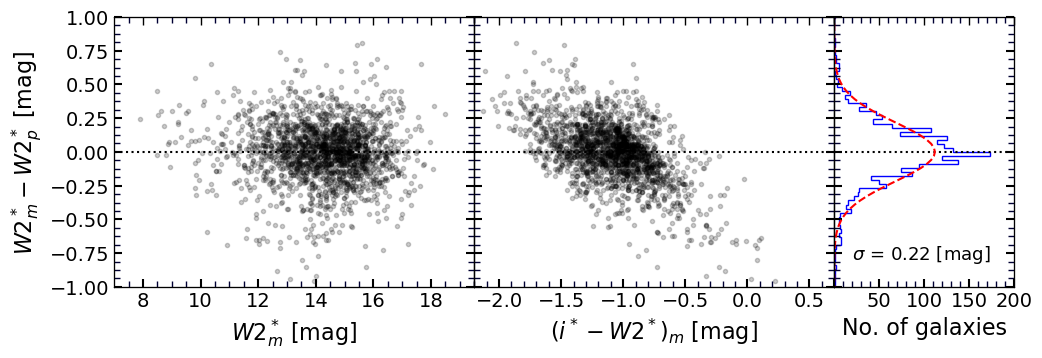

In [14]:
W2_lst  = w2_s[indx]
w2p_lst = w2_ss[indx]
i_w2    = i_s[indx]-w2_s[indx]


#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [-2.2,0.7], [-1,1])
ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,200], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


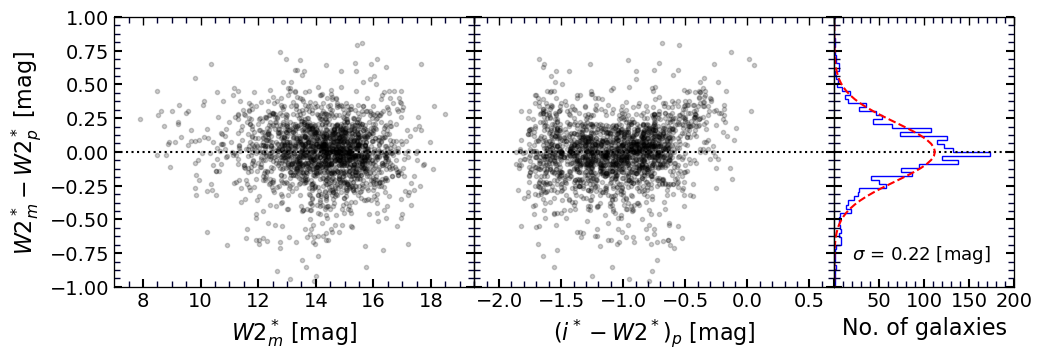

In [15]:
W2_lst  = w2_s[indx]
w2p_lst = w2_ss[indx]
i_w2    = i_ss[indx]-w2_ss[indx]


#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [-2.2,0.7], [-1,1])
ax_.set_xlabel(r'$(i^*-W2^*)_p$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,200], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


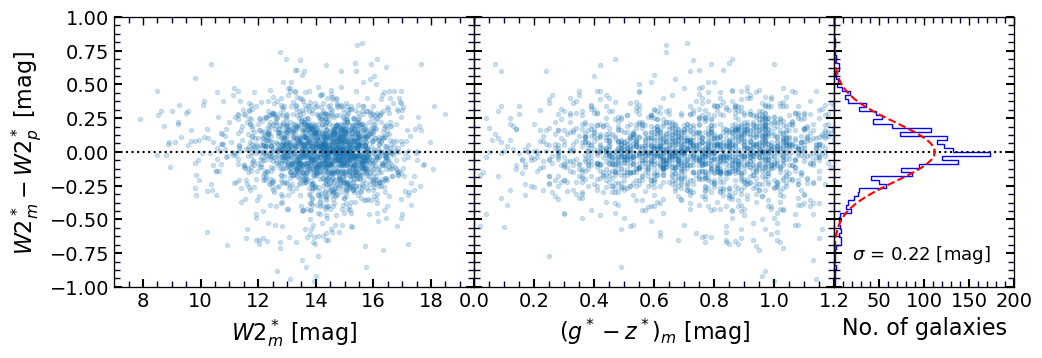

In [16]:
W2_lst  = w2_s[indx]
w2p_lst = w2_ss[indx]
i_w2    = g_s[indx]-z_s[indx]


#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

ax_.plot(i_w2, W2_lst-w2p_lst, '.', alpha=0.2)
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [0,1.2], [-1,1])
ax_.set_xlabel(r'$(g^*-z^*)_m$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,200], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)



Text(0,0.5,'$W2^*_m-W2^*_p$ [mag]')

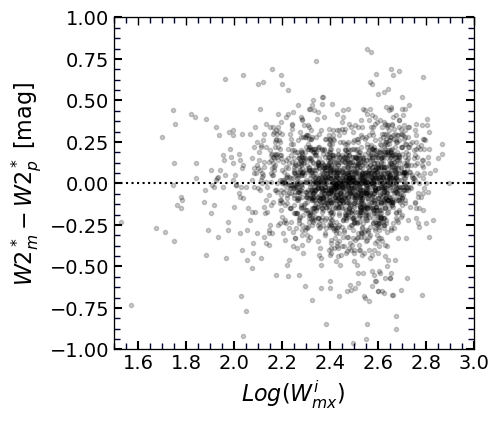

In [17]:
fig = py.figure(figsize=(4.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-1,1])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)



In [18]:
print rmsMaker(W2_lst-w2p_lst)
print st.biweight_location(W2_lst-w2p_lst), np.sqrt(st.biweight_midvariance(W2_lst-w2p_lst))

0.19107240770819198
0.009230448147091726 0.20228482216379098


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


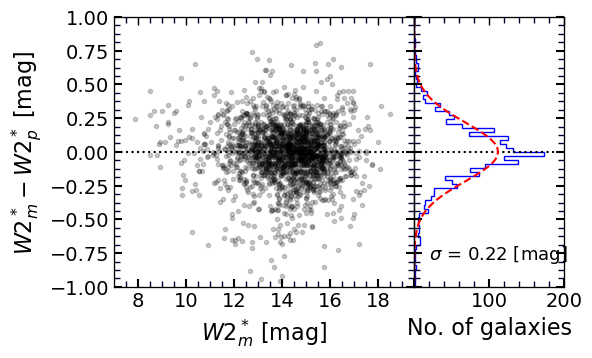

In [19]:
W2_lst  = w2_s[indx]
w2p_lst = w2_ss[indx]
i_w2    = i_s[indx]-w2_s[indx]


#################################################################
fig = py.figure(figsize=(6, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2, width_ratios=[1,0.5]) 

ax = plt.subplot(gs[0])
# ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[1])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

# ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='orange', alpha=0.2)
# ax_.plot([-20,20],[0,0], 'k:')
# set_axes([ax_], [-2.2,0.7], [-1,1])
# ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
# plt.setp(ax_.get_yticklabels(), visible=False)
# plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,200], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''), Text(0,0,'500'), Text(0,0,'1000'), Text(0,0,'1500')]

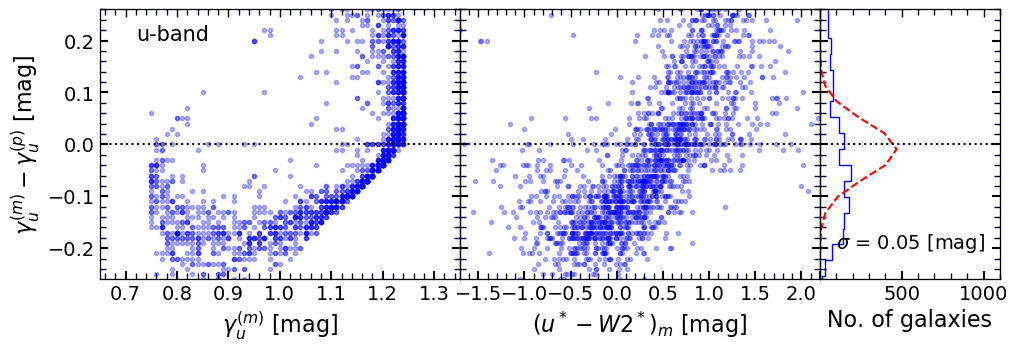

In [20]:
gamma_m = gamma_u[indx]
gamma_p = gamma_p_u[indx]
u_w2    = u_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='blue', alpha=0.3)
ax_.plot(u_w2, gamma_m-gamma_p, '.', color='blue', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.1)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,1100], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_u^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(u^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_u^{(m)}-\gamma_u^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.72,0.20, 'u-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1100],[0,0], 'k:')
set_axes([ax], [0.65,1.35], [-0.26,0.26])
set_axes([ax_], [-1.7,2.2], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


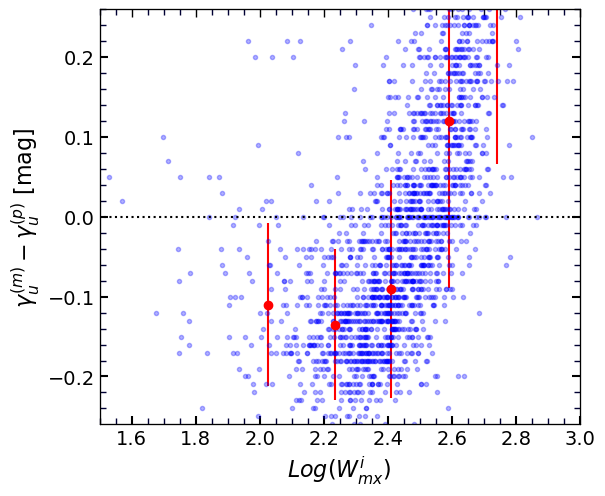

In [21]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], gamma_m-gamma_p, '.', color='b', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-0.26,0.26])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=16)
ax.set_ylabel(r'$\gamma_u^{(m)}-\gamma_u^{(p)}$'+' [mag]', fontsize=16)


y = gamma_m-gamma_p
x = logWimx[indx]

for x0 in np.arange(1.9,3.0,0.2):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+0.2)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), fmt='o', color='red')
    


In [22]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.1786464309863785
-0.005924997050177739 0.19121538175385283


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

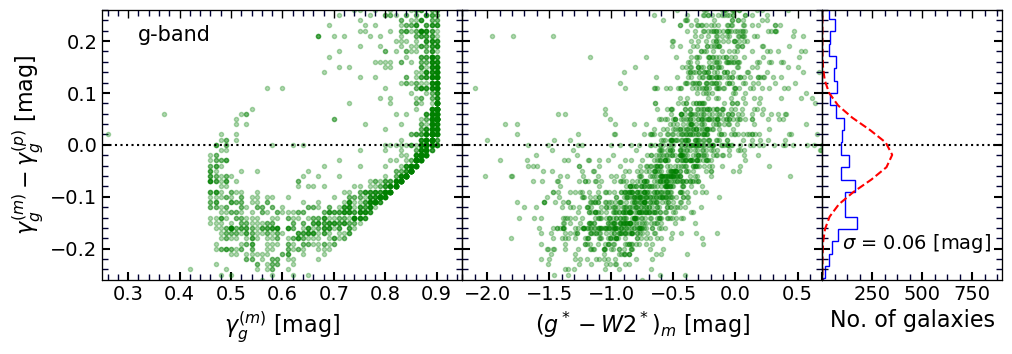

In [23]:
gamma_m = gamma_g[indx]
gamma_p = gamma_p_g[indx]
g_w2    = g_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='green', alpha=0.3)
ax_.plot(g_w2, gamma_m-gamma_p, '.', color='green', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.1)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_g^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(g^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_g^{(m)}-\gamma_g^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.32,0.20, 'g-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [0.25,0.95], [-0.26,0.26])
set_axes([ax_], [-2.2,0.7], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

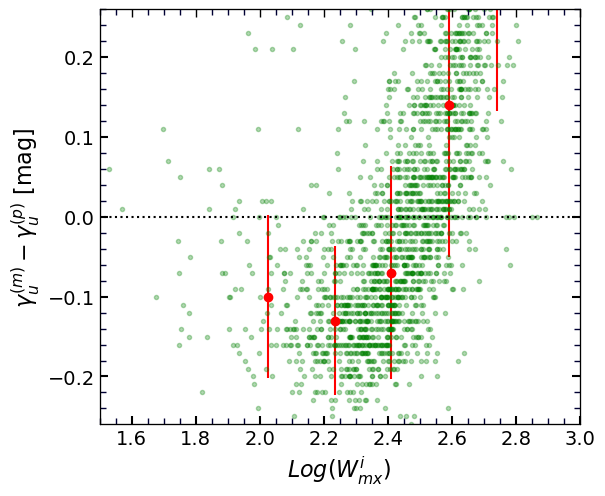

In [24]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], gamma_m-gamma_p, '.', color='g', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-0.26,0.26])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=16)
ax.set_ylabel(r'$\gamma_u^{(m)}-\gamma_u^{(p)}$'+' [mag]', fontsize=16)


y = gamma_m-gamma_p
x = logWimx[indx]

for x0 in np.arange(1.9,3.0,0.2):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+0.2)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), fmt='o', color='red')
    


In [25]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.18608948514736684
0.008489886414870803 0.19249943068695796


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

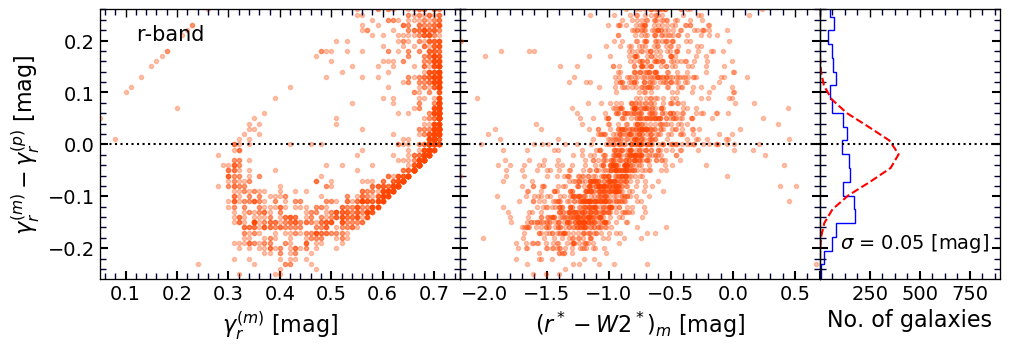

In [26]:
gamma_m = gamma_r[indx]
gamma_p = gamma_p_r[indx]
r_w2    = r_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orangered', alpha=0.3)
ax_.plot(r_w2, gamma_m-gamma_p, '.', color='orangered', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.1)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=40, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_r^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(r^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_r^{(m)}-\gamma_r^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.12,0.20, 'r-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [0.05,0.75], [-0.26,0.26])
set_axes([ax_], [-2.2,0.7], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [27]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.18377549373832583
0.01669351743165577 0.18141430512255421


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

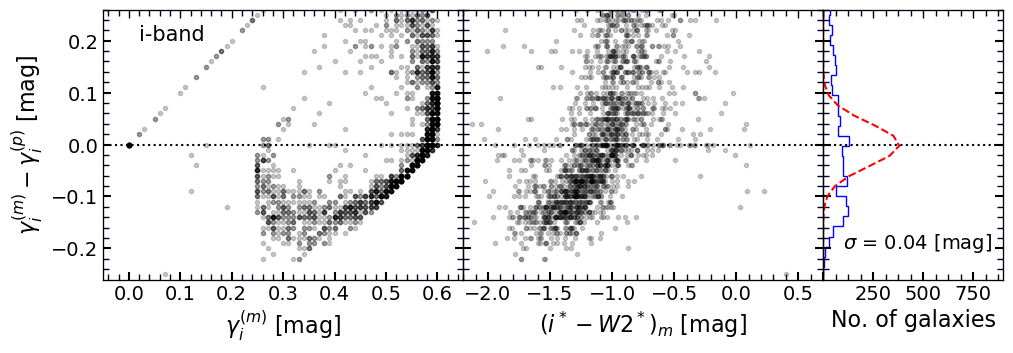

In [28]:
gamma_m = gamma_i[indx]
gamma_p = gamma_p_i[indx]
i_w2    = i_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='k', alpha=0.2)
ax_.plot(i_w2, gamma_m-gamma_p, '.', color='k', alpha=0.2)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.07)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_i^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.02,0.20, 'i-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [-0.05,0.65], [-0.26,0.26])
set_axes([ax_], [-2.2,0.7], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

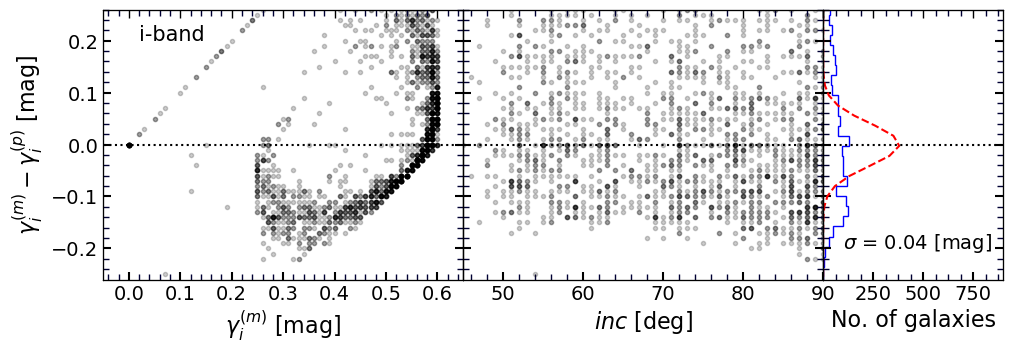

In [29]:
gamma_m = gamma_i[indx]
gamma_p = gamma_p_i[indx]
i_w2    = inc[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='k', alpha=0.2)
ax_.plot(i_w2, gamma_m-gamma_p, '.', color='k', alpha=0.2)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.07)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_i^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$inc$'+' [deg]', fontsize=16)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.02,0.20, 'i-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [-0.05,0.65], [-0.26,0.26])
set_axes([ax_], [45,90], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [30]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.17695399056430547
0.029438007993718797 0.17375181965563732


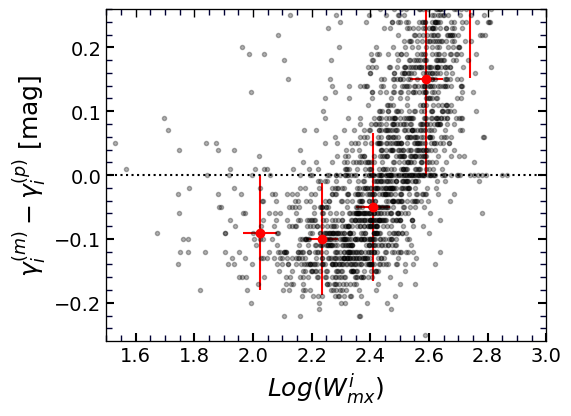

In [31]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], gamma_m-gamma_p, '.', color='k', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-0.26,0.26])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=18)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=18)


y = gamma_m-gamma_p
x = logWimx[indx]

for x0 in np.arange(1.9,3.0,0.2):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+0.2)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), xerr=np.std(x_), fmt='o', color='red')
    


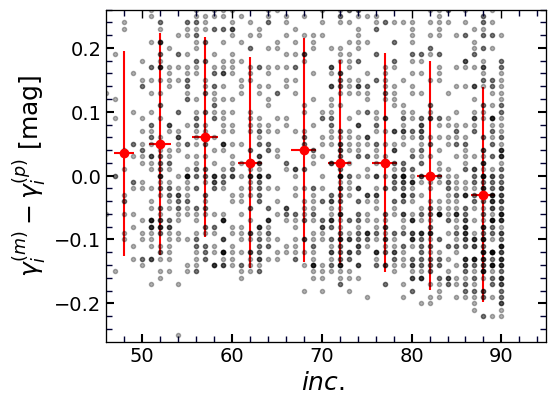

In [32]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(inc[indx], gamma_m-gamma_p, '.', color='k', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [46,95], [-0.26,0.26])
ax.set_xlabel(r'$inc.$'+' ', fontsize=18)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=18)


y = gamma_m-gamma_p
x = inc[indx]

for x0 in np.arange(45,90,5):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+5)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), xerr=np.std(x_), fmt='o', color='red')
    


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

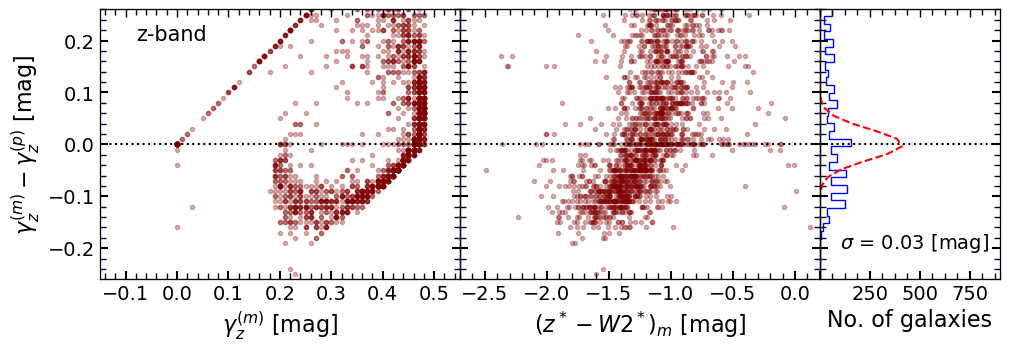

In [33]:
gamma_m = gamma_z[indx]
gamma_p = gamma_p_z[indx]
z_w2    = z_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='maroon', alpha=0.3)
ax_.plot(z_w2, gamma_m-gamma_p, '.', color='maroon', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.05)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_z^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(z^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_z^{(m)}-\gamma_z^{(p)}$'+' [mag]', fontsize=16)

ax.text(-0.08,0.20, 'z-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [-0.15,0.55], [-0.26,0.26])
set_axes([ax_], [-2.7,0.2], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [34]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.15890764533360988
0.04860911939814471 0.1530280984744859


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''), Text(0,0,'500'), Text(0,0,'1000'), Text(0,0,'1500')]

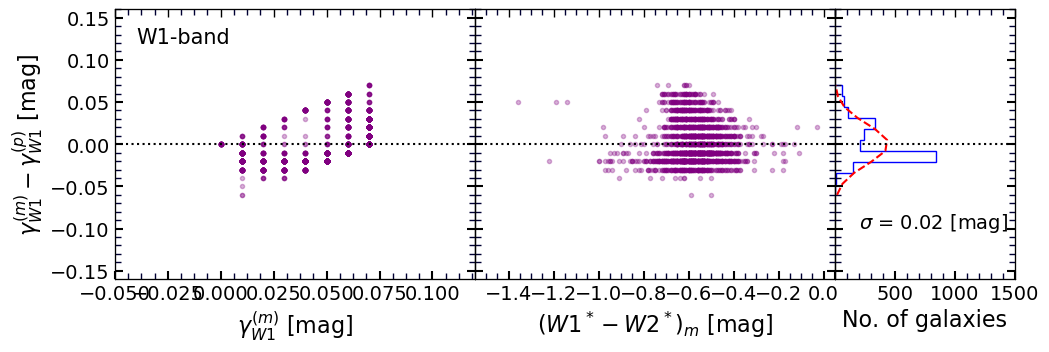

In [35]:
gamma_m = gamma_w1[indx]
gamma_p = gamma_p_w1[indx]
w1_w2    = w1_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='purple', alpha=0.3)
ax_.plot(w1_w2, gamma_m-gamma_p, '.', color='purple', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.07)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(200,-0.1, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=10, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,1500], [-0.16,0.16])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_{W1}^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(W1^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_{W1}^{(m)}-\gamma_{W1}^{(p)}$'+' [mag]', fontsize=16)

ax.text(-0.04,0.12, 'W1-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,2000],[0,0], 'k:')
set_axes([ax], [-0.05,0.12], [-0.16,0.16])
set_axes([ax_], [-1.55,0.05], [-0.16,0.16])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [36]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.02419734495129826
0.0007984924448252494 0.024382561780573766


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


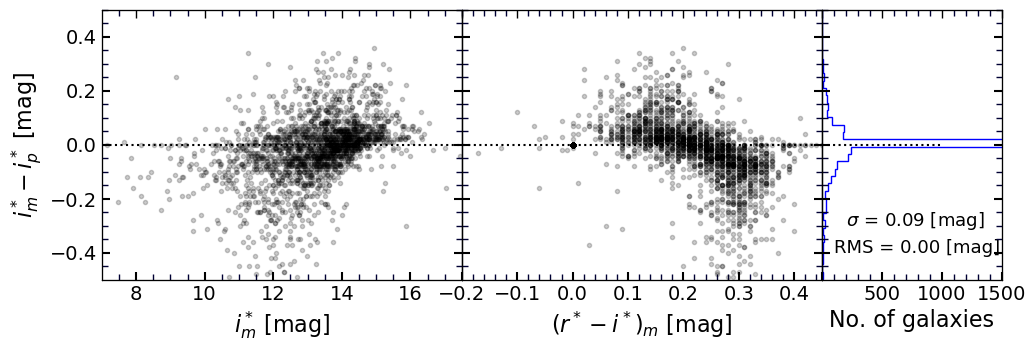

In [37]:
indx, = np.where(R_source==2)    # W2 is used for reddening correction

W2_lst  = i_s[indx]
w2p_lst = i_ss[indx]
i_w2    = r_s[indx]-i_s[indx]


#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,17.5], [-0.5,0.5])
ax.set_xlabel(r'$i^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$i^*_m-i^*_p$'+' [mag]', fontsize=16)

ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [-0.2,0.45], [-0.5,0.5])
ax_.set_xlabel(r'$(r^*-i^*)_m$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
rms = np.sqrt(np.median(XX**2))
ax__.text(100,-0.4, 'RMS = '+'%.2f'%rms+' [mag]', fontsize=13, color='k')
ax__.text(200,-0.3, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,1500], [-0.5,0.5])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
# ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

In [38]:
print rmsMaker(W2_lst-w2p_lst)
print st.biweight_location(W2_lst-w2p_lst), np.sqrt(st.biweight_midvariance(W2_lst-w2p_lst))

0.03591510200243541
0.0 0.0


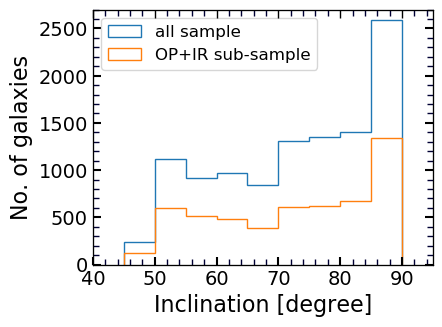

In [39]:
indx, = np.where(np.logical_or(R_source==2,R_source==1))    # W2 is used for reddening correction
sub_inc = table['inc'][indx]
inc = table['inc']


fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(inc, bins=9, histtype='step', label='all sample')
ax.hist(sub_inc, bins=9, histtype='step', label='OP+IR sub-sample')

ax.legend(prop={'size': 12}, loc=2)

ax.set_xlabel('Inclination [degree]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)


set_axes([ax], [40,95], [0,2700])

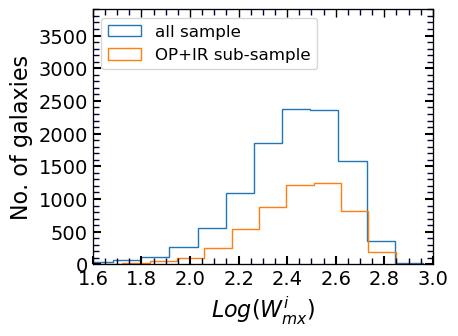

In [40]:
indx, = np.where(np.logical_or(R_source==2,R_source==1))    # W2 is used for reddening correction
i0_sub = table['logWimx'][indx]


fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(table['logWimx'], bins=15, histtype='step', label='all sample')
ax.hist(i0_sub, bins=15, histtype='step', label='OP+IR sub-sample')

ax.legend(prop={'size': 12}, loc=2)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)


set_axes([ax], [1.6,3.0], [0,3900])

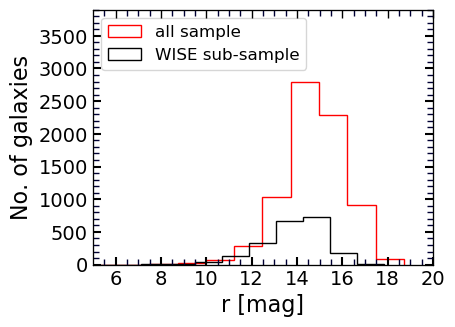

In [41]:
indx, = np.where(np.logical_or(R_source==2,R_source==1))    # W2 is used for reddening correction
r0_sub = table['r'][indx]


fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(r0, bins=15, histtype='step', label='all sample', color='red')
ax.hist(r0_sub, bins=15, histtype='step', label='WISE sub-sample', color='k')

ax.legend(prop={'size': 12}, loc=2)

ax.set_xlabel('r [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)


set_axes([ax], [5,20], [0,3900])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

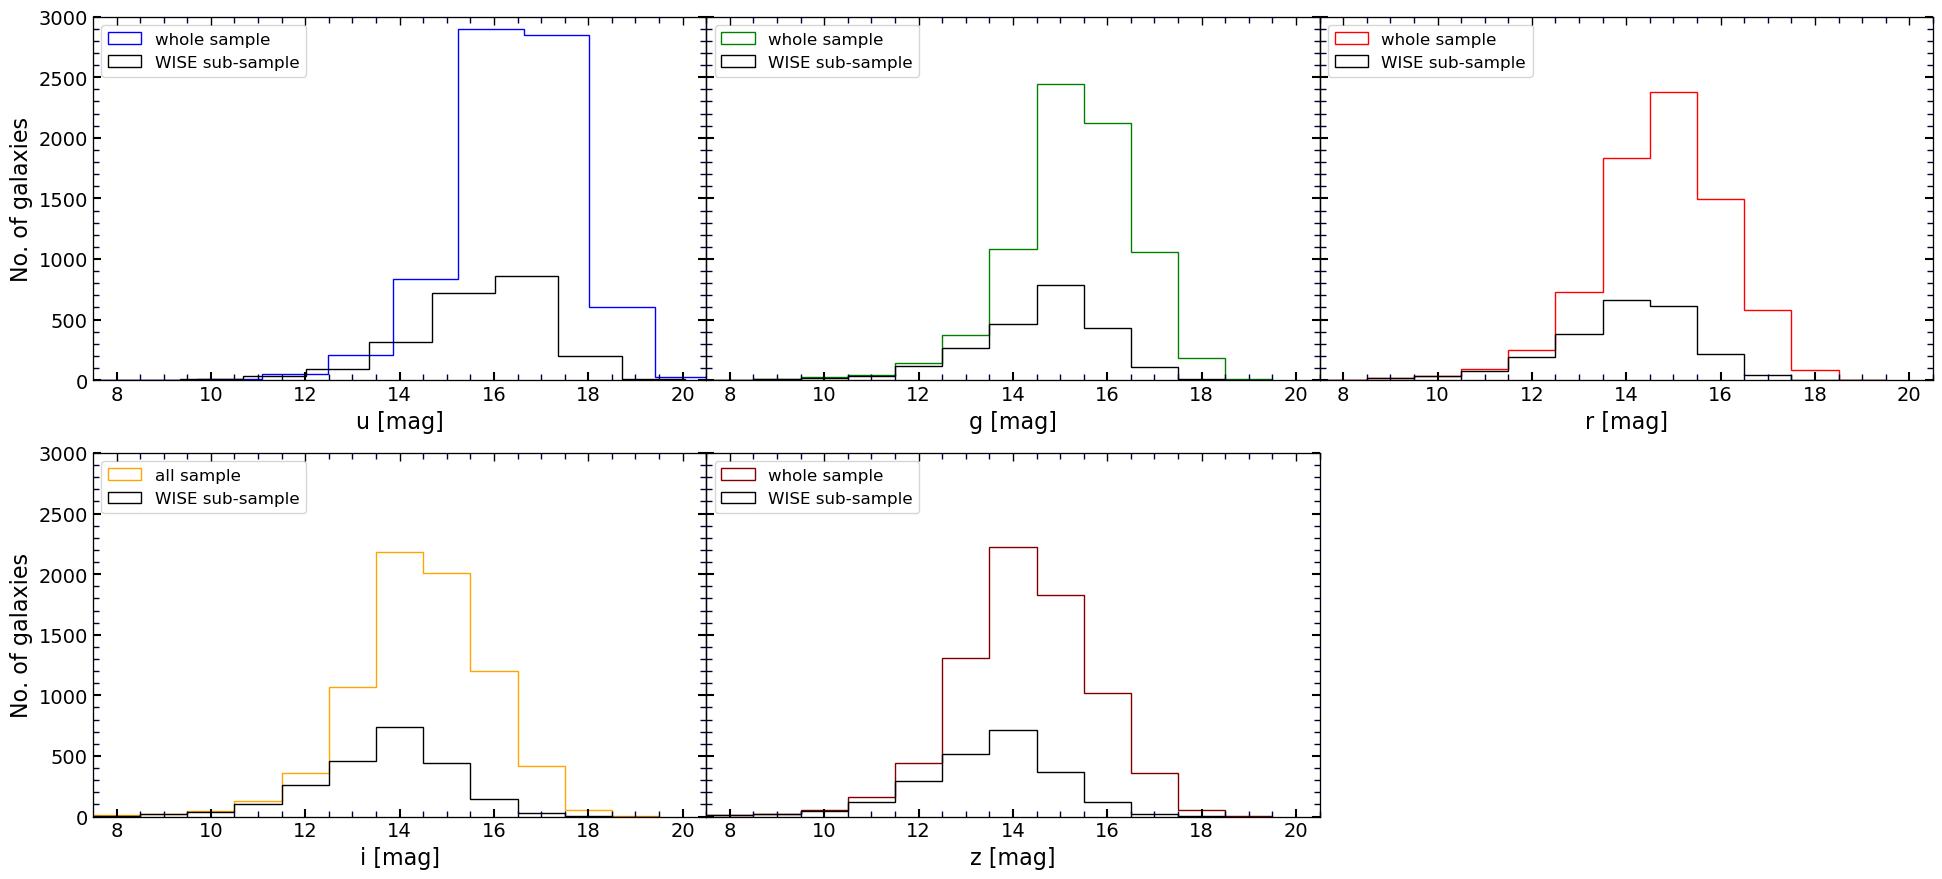

In [42]:
indx, = np.where(i0>5)   # W2 is used for reddening correction
u0_  = table['u'][indx]
g0_  = table['g'][indx]
r0_  = table['r'][indx]
i0_  = table['i'][indx]
z0_  = table['z'][indx]
indx, = np.where(w10>5)   # W2 is used for reddening correction
w10_ = table['w1'][indx]
w20_ = table['w2'][indx]

indx, = np.where(np.logical_and(Wqlt>0, i0>5))   # W2 is used for reddening correction
u0_sub  = table['u'][indx]
g0_sub  = table['g'][indx]
r0_sub  = table['r'][indx]
i0_sub  = table['i'][indx]
z0_sub  = table['z'][indx]


fig = py.figure(figsize=(20, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(2, 3) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])



bins = np.arange(5.5,20.5,1)

ax = ax1
ax.hist(u0_, bins=15, histtype='step', label='whole sample', color='b')
ax.hist(u0_sub, bins=15, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('u [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])


ax = ax2
ax.hist(g0_, bins, histtype='step', label='whole sample', color='g')
ax.hist(g0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('g [mag]', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])
plt.setp(ax.get_yticklabels(), visible=False)


ax = ax3
ax.hist(r0_, bins, histtype='step', label='whole sample', color='r')
ax.hist(r0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('r [mag]', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])
plt.setp(ax.get_yticklabels(), visible=False)

ax = ax4
n, bins, patches = ax.hist(i0_, bins, histtype='step', label='all sample', color='orange')
ax.hist(i0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('i [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])

ax = ax5
ax.hist(z0_, bins, histtype='step', label='whole sample', color='maroon')
ax.hist(z0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('z [mag]', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])
plt.setp(ax.get_yticklabels(), visible=False)



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

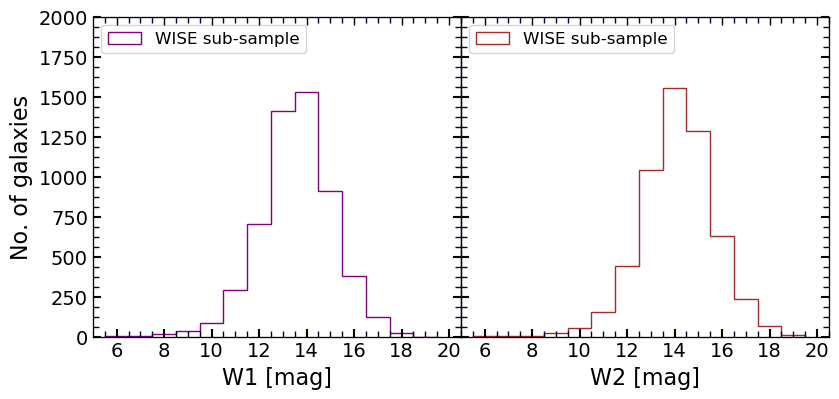

In [43]:
fig = py.figure(figsize=(8, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax = ax1
ax.hist(w10_, bins, histtype='step', label='WISE sub-sample', color='purple')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('W1 [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)
set_axes([ax], [5,20.5], [0,2000])

ax = ax2
ax.hist(w20_, bins, histtype='step', label='WISE sub-sample', color='brown')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('W2 [mag]', fontsize=16)
set_axes([ax], [5,20.5], [0,2000])
plt.setp(ax.get_yticklabels(), visible=False)


355
[22446]


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


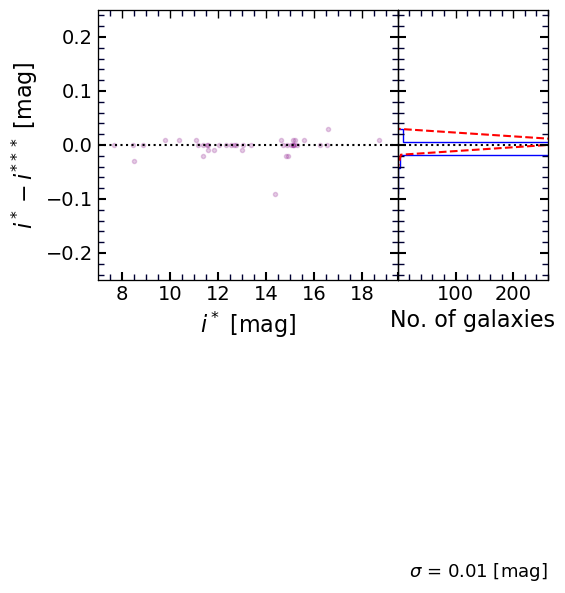

In [44]:
indx, = np.where(R_source==1)    # W2 is used for reddening correction
print len(indx)

iddd = table['pgc'][indx]
W2_lst  = table['i_s'][indx]
w2p_lst = table['i_sss'][indx]

print iddd[np.where(np.abs(W2_lst-w2p_lst)>0.05)]

#################################################################
fig = py.figure(figsize=(6, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2, width_ratios=[1,0.5]) 

ax = plt.subplot(gs[0])
# ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[1])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='purple', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-0.25,0.25])
ax.set_xlabel(r'$i^*$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$i^*-i^{***}$'+' [mag]', fontsize=16)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=5, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,260], [-0.25,0.25])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)